# Use case 2: Shower profiles

In [1]:
import showermodel as sm
import pandas as pd
import numpy as np
import toml

This notebook illustrates how to use the following classes and their methods:
- `Atmosphere` : Atmospheric profile and discretization.
- `Profile` : Shower longitudinal profile.
- `Fluorescence` : Fluorescence production.
- `Cherenkov` : Cherenkov light production.

These classes, along with the `Track` class described in UC1, are wrapped by the `Shower` class, which is also described here.

### Construction of an atmospheric profile

The `Atmosphere` class uses the atmospheric models that are built in the CORSIKA code, i.e., those corresponding to the CORSIKA parameter MODATM from 1 to 29, except for 9 and 10 that are reserved for user-defined models. These models parameterize the atmosphere in 5 layers. In the lower 4 layers, the air density has an exponential dependence on altitude, whereas a linear dependence is assumed in the top layer. Pressure and temperature are calculated assuming constant acceleration of gravity and an ideal gas with the molar mass of dry air. In `ShowerModel` the atmospheric model is selected via the parameter `atm_model`. The default atmospheric model is the U.S. standard atmosphere and corresponds to `atm_model = 1` (corresponding to MODATM = 1 in CORSIKA).

These atmospheric models ignore the water vapor, which is relevant for the fluorescence emission. Therefore, a simple exponential water-pressure profile (from recommendation ITU-R P.835-6) is also implemented in `ShowerModel`. This uses two parameters:

- `rho_w_sl` : Water-vapor density in g/cm$^3$ at sea level. Set to 0 for dry air. Default 7.5e-6 g/cm$^3$.
- `h_scale` : Scale height in km of the exponential water density. Default 2 km.

In addition, `Atmosphere` allows you to specify the ground level and atmosphere discretization via the parameters `h0`, `h_top` and `N_steps`, as in the `Track` class (see UC1). In fact, the discretization of `Track`, `Profile`, `Cherenkov`, `Fluorescence`, etc. is based on an `Atmosphere` object that is stored as an attribute (see examples for `Profile` later on).

In [2]:
# Default Atmosphere object
# atmosphere = sm.Atmosphere()

# Setting the ground level, the atmospheric model and the number of discretization steps
atmosphere = sm.Atmosphere(h0=1.8, atm_model=17, N_steps=600)

# Setting the water pressure profile
# atmosphere = sm.Atmosphere(h0=1.8, atm_model=17, N_steps=600, rho_w_sl=9.e-6, h_scale=1.)

`Atmosphere` is a subclass of `DataFrame` and it contains all the relevant parameters of the atmospheric profile.

- `h` : Height in km a.s.l.
- `X_vert` : Vertical depth in g/cm$^2$.
- `rho` : Mass density in g/cm$^3$.
- `temp` : Temperature in K.
- `P` : Pressure in hPa.
- `P_w` : Water-vapor pressure in hPa.
- `E_th` : Cherenkov energy threshold in MeV (at 350 nm).
- `r_M` : Molière radius in km.

In [3]:
atmosphere

,h,X_vert,rho,temp,P,P_w,E_th,r_M
0,1.892524,820.877247,1.017218e-03,275.689079,805.005585,3.704397e+00,23.450154,0.094452
1,2.077573,802.235096,9.976824e-04,274.703934,786.723881,3.364961e+00,23.677999,0.096301
2,2.262622,783.950973,9.785216e-04,273.699498,768.793281,3.056373e+00,23.908111,0.098187
3,2.447670,766.018002,9.597289e-04,272.675394,751.207044,2.775847e+00,24.140506,0.100109
4,2.632719,748.429438,9.412970e-04,271.631237,733.958555,2.520847e+00,24.375204,0.102070
...,...,...,...,...,...,...,...,...
595,111.996481,0.000083,1.000000e-09,28.448148,0.000082,1.633237e-10,23648.351576,96077.859812
596,112.181530,0.000065,1.000000e-09,22.126337,0.000064,1.270295e-10,23648.351488,96077.859812
597,112.366578,0.000046,1.000000e-09,15.804527,0.000045,9.073538e-11,23648.351330,96077.859812
598,112.551627,0.000028,1.000000e-09,9.482716,0.000027,5.444123e-11,23648.350960,96077.859812


`Atmosphere` has some useful attributes and methods.

In [4]:
print("Observation level in km a.s.l.:", atmosphere.h0)
print("Height (km a.s.l.) corresponding to a vertical depth of 50 g/cm2:", np.around(atmosphere.Xv_to_h(50.), 3))

Observation level in km a.s.l.: 1.8
Height (km a.s.l.) corresponding to a vertical depth of 50 g/cm2: 20.703


Help on `Atmosphere`.

In [5]:
# atmosphere?

### User-defined atmospheric models

There are two ways to personalize the atmospheric profile. In the first place, you may have your own library of atmospheric models with the same parameterization as the CORSIKA ones. For this purpose, the file 'atm_models.toml' is available in the 'extra' folder included in the `ShowerModel` package. This file contains the list of the built-in CORSIKA atomspheric models, of which parameters are stored in a key-value format.

Once a model is modified or new one is created and assigned a different key, it can be selected via the parameter `atm_model`. You can also change the default value of the parameter `atm_model` stored in the file 'showermodel_config.toml', which is available in the 'extra' folder too. This way, if `atm_model` is set to the key of your personalized atmospheric model, this will be the default one. The file 'showermodel_config.toml' also contains the parameters `h0`, `h_top`, `N_steps`, `rho_w_sl` and `h_scale`. Both modified files must be placed in the working directory and keep their original names for `ShowerModel` to find them.

Note: Atmospheric models with a different number of layers (at least 2) can be defined, provided that the first layers are exponential and the last one is linear. See the comments inside 'atm_models.toml' for details about layer parameters and units.

In [6]:
# Parameters of model 2 stored in atm_models.toml
atm_models = toml.load("../extra/atm_models.toml")
atm_models['2']

# The atmospheric profile is generated in accordance with this model when atm_model=2 is selected
# atm = sm.Atmosphere(atm_model=2)
# atm.info

{'info': 'AT115 Central European atmosphere for Jan. 15, 1993',
 'h_low': [0.0, 4.0, 10.0, 40.0, 100.0],
 'a': [-118.1277, -154.258, 0.4191499, 0.00054094056, 0.01128292],
 'b': [1173.9861, 1205.7625, 1386.7807, 555.8935, 1.0],
 'c': [919546.0, 963267.92, 614315.0, 739059.6, 1000000000.0]}

Other option to define a new atmosphere is passing in a `DataFrame` containing the atmospheric profile to `atm_model`. This `DataFrame` must have two columns: one labelled as 'h', with height in km, and the other one labelled either as 'X_vert' or 'P', depending on whether the vertical depth in g/cm$^2$ or the pressure in hPa is given. In doing so, the `Atmosphere` object is constructed by interpolation from the `DataFrame` using the atmosphere discretization defined by the parameters `h0`, `h_top` and `N_steps`. Note that the water-pressure profile is independently determined by the parameters `rho_w_sl` and `h_scale`.

In the example below, a profile stored in an excel file is used. In this case, the profile is defined in terms of pressure.

In [7]:
# Load file into a DataFrame
df = pd.read_excel('../extra/mean_annual_global_reference_atmosphere.xlsx')
df

,h,P
0,0.000000,1013.250000
1,1.222457,874.783079
2,2.445385,752.053153
3,3.668783,643.653845
4,4.892652,548.268352
...,...,...
68,93.777778,0.000942
69,95.333333,0.000717
70,96.888889,0.000546
71,98.444444,0.000417


In [8]:
# Interpolate atmosphere from DataFrame
atmosphere = sm.Atmosphere(atm_model=df, h0=1.8, N_steps=500)
atmosphere

,h,X_vert,rho,temp,P,P_w,E_th,r_M
0,1.8982,820.546159,1.030118e-03,272.126993,804.680899,3.646172e+00,23.302332,0.093269
1,2.0946,800.865247,1.010146e-03,270.851299,785.380517,3.289643e+00,23.530875,0.095113
2,2.2910,781.656384,9.906527e-04,269.556601,766.543058,2.967701e+00,23.760615,0.096984
3,2.4874,762.792481,9.713875e-04,268.268329,748.043888,2.677268e+00,23.994489,0.098908
4,2.6838,743.968853,9.517228e-04,267.054428,729.584215,2.415875e+00,24.240586,0.100952
...,...,...,...,...,...,...,...,...
495,99.1162,0.000380,7.259051e-10,178.622937,0.000372,7.444101e-10,27756.259756,132355.944146
496,99.3126,0.000367,7.259051e-10,172.738752,0.000360,7.198878e-10,27756.259755,132355.944146
497,99.5090,0.000355,7.259051e-10,167.048403,0.000348,6.961733e-10,27756.259754,132355.944146
498,99.7054,0.000343,7.259051e-10,161.545506,0.000337,6.732400e-10,27756.259752,132355.944146


You may also modify directly an existing `Atmosphere` object. However, this is not advisable because if you change some column of `Atmospheric` by hand, the other columns and attributes are not updated, which may cause inconsistencies. 

### Construction of shower profiles

The `Profile` class generates the longitudinal profile of a shower. It includes:

- `X` : Slant depth in g/cm$^2$.
- `s` : Shower age.
- `dX` : Discretization step along the shower track in g/cm$^2$.
- `E_dep` : Energy deposit in MeV.
- `N_ch` : Average number of charged particles with energy greater than 1 MeV.

The default `Profile` object assumes a 10 TeV vertical electromagnetic shower with a longitudinal profile described by the Greisen function, where the depth of maximum is obtained from the Heitler model. But you can select the shower energy `E` (MeV), the direction `theta` / `az` (degrees), the depth of maximum `X_max` (g/cm$^2$), the height of the first interaction point `zi` (km above ground level) and the profile model `prf_model`, as illustrated in the examples below.

In the same way as `Track`, the discretization of `Profile` is based on an `Atmosphere` object defined by the parameters `h0`, `h_top`, `N_steps` and `atm_model`. Alternatively, an existing `Atmosphere` object can be input via the parameter `atmosphere`. In either case, the `Atmosphere` object is stored as an attribute of `Profile`.

In [9]:
# Default Profile object
# profile = sm.Profile()

# Greisen profile for a 1000 GeV shower starting at 90 km above ground level with zenith angle of 20 degrees.
# The depth of maximum is set to 300 g/cm2
atmosphere = sm.Atmosphere(h0=2.0, atm_model=17, N_steps=500)
profile = sm.Profile(E=1000000., theta=20., X_max=300., zi=90., atmosphere=atmosphere)

# Equivalent one-step procedure
# profile = sm.Profile(E=1000000, theta=20., X_max=300., h0=2.0, atm_model=17, N_steps=500)

# The atmosphere is stored as an attribute of profile
# profile.atmosphere

profile

,X,s,dX,E_dep,N_ch
0,850.192923,1.758786e+00,23.451852,724.610198,11.663520
1,827.011351,1.738623e+00,22.913376,948.112596,15.635342
2,804.362049,1.718279e+00,22.387265,1226.646837,20.724948
3,782.232794,1.697759e+00,21.873234,1569.528937,27.169008
4,760.611647,1.677066e+00,21.371005,1986.521000,35.231586
...,...,...,...,...,...
401,0.000389,1.945883e-06,0.000092,0.000147,0.336483
402,0.000299,1.493277e-06,0.000089,0.000143,0.336467
403,0.000211,1.054070e-06,0.000087,0.000139,0.336451
404,0.000126,6.278677e-07,0.000084,0.000134,0.336435


Note: The above `Profile` object has 406 steps, despite of `N_steps=500`, because the shower does not start at the top of the atmosphere, but at 90 km above ground.

Apart from the Greisen model of the longitudinal profile, the Gaisser-Hillas profile is also available for hadronic showers. It can be selected setting `prf_model = 'Gaisser-Hillas'` and the optional parameters `X_max`, `X0_GH` and `lambda_GH`. If these parameters are not given, they are interpolated from data obtained by the Pierre Auger Observatory at the input shower energy `E`.

In [10]:
# Gaisser-Hillas profile for a 1 EeV proton shower. A default value for lambda is used
profile2 = sm.Profile(E=1.e12, theta=20., prf_model='Gaisser-Hillas', X_max=500., X0_GH=-10.)

`Profile` objects can also be constructed from a numerical energy deposit profile (e.g., obtained by CORSIKA). To do that, a `DataFrame` object has to be generated with two columns: slant depth in g/cm$^2$ and dE/dX in MeV.cm$^2$/g. The example below uses an energy deposit profile that is stored in a file.

In [11]:
# Numerical energy deposit profile generated by CORSIKA: average of 1000 vertical showers induced by 1000 GeV gamma rays
# In that simulation, the total atmospheric depth was 800 g/cm2
prf_model = pd.read_fwf('../extra/Edep_profile_1000GeV_1000sh_0deg.dat', skiprows = 12, names=['X', 'dE_dX'])
prf_model.dE_dX *= 1000./10.  # Original data is given in GeV in steps of 10 g/cm2

atmosphere = sm.Atmosphere()
h0 = atmosphere.Xv_to_h(800.)  # Ground level consistent with simulation
profile3 = sm.Profile(E=1000000., theta=0., prf_model=prf_model, h0=h0)

`Profile` objects have a method to plot both the number of charged particles `N_ch` (with energy above 1 MeV) and the energy deposit profile `E_dep / dX` in MeV.cm$^2$/g as a function of slant depth `X` in g/cm$^2$

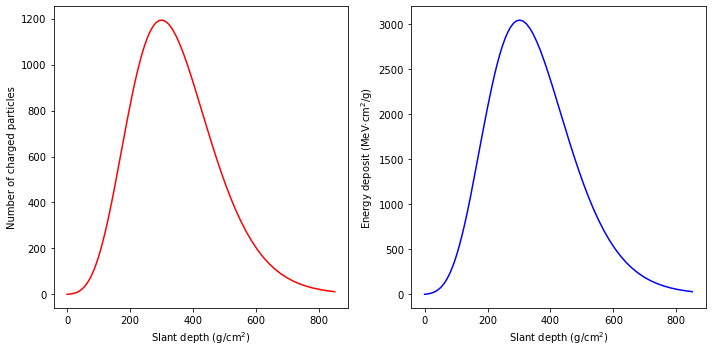

In [12]:
profile.show();

The generated plots can be stored in `AxesSubplot` objects for later modification.

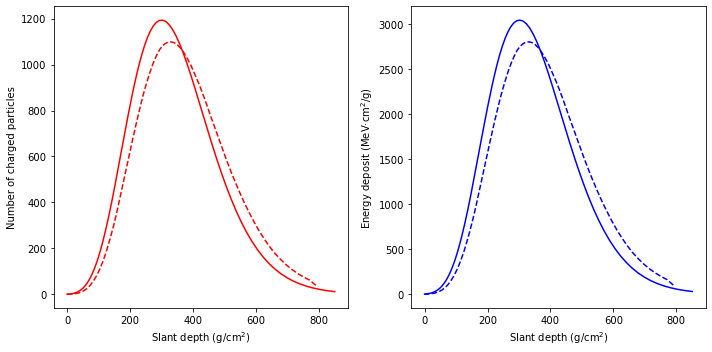

In [13]:
# Example of comparison of two profiles in the same plot
ax1, ax2 = profile.show();
ax1.plot(profile3.X, profile3.N_ch, 'r--');
ax2.plot(profile3.X, profile3.E_dep/profile3.dX, 'b--');

Help on `Profile`, including the full list of input parameters, attributes and methods.

In [14]:
# sm.Profile?

### Fluorescence and Cherenkov light production

The `Cherenkov` and `Fluorescence` classes calculate the production of the respective light components based on available models for a 1D shower profile.  

- `Cherenkov` : F. Nerling et al., Astropart. Phys. 24(2006)241.  
- `Fluorescence` : D. Morcuende et al., Astropart. Phys. 107(2019)26 and references therein.

They only need a `Profile` object.

In [15]:
cherenkov = sm.Cherenkov(profile)
fluorescence = sm.Fluorescence(profile)

# Equivalent methods of Profile
# cherenkov = profile.Cherenkov()
# fluorescence = profile.Fluorescence()

Both classes are subclasses of `DataFrame`. `Cherenkov` contains the number of Cherenkov photons `N_ph` emitted by each shower point in the reference 290 - 430 nm wavelength interval, where the wavelength spectrum is assumed to follow a $1/\lambda^2$ distribution. `Cherenkov` also contains other parameters that determine the angular disctribution of Cherenkov emission according to the model from F. Nerling et al.

In [16]:
cherenkov

,N_ph,a,theta_c,b,theta_cc
0,17236.255267,1.196704,5.274431,0.063162,9.561802
1,22713.065357,1.190744,5.237536,0.061073,10.017076
2,29601.386194,1.184662,5.200891,0.059013,10.470122
3,38147.264856,1.178458,5.164494,0.056982,10.920837
4,48657.442586,1.172132,5.128345,0.054983,11.369115
...,...,...,...,...,...
401,0.003484,0.424891,0.121387,0.055108,1.275659
402,0.003365,0.424891,0.120287,0.055108,1.264097
403,0.003250,0.424891,0.119197,0.055108,1.252640
404,0.003139,0.424890,0.118117,0.055108,1.241287


`Fluorescence` contains the number of fluorescence photons at each of the 57 fluorescence bands in the 280 - 670 nm interval.

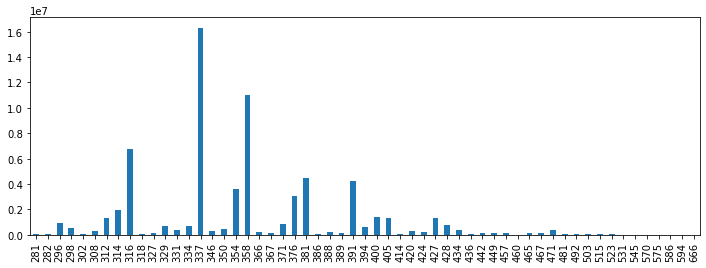

In [17]:
fluorescence.sum().plot(kind='bar', figsize=(12,4));

Note: wavelength is not to scale.

Both classes include a method to plot the light production as a function of slant depth for the reference 290 - 430 nm interval of interest to astroparticle experiments.

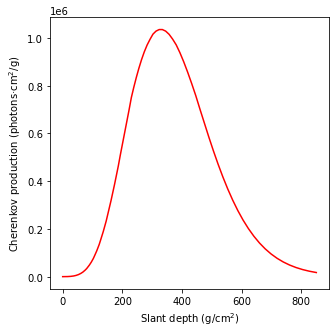

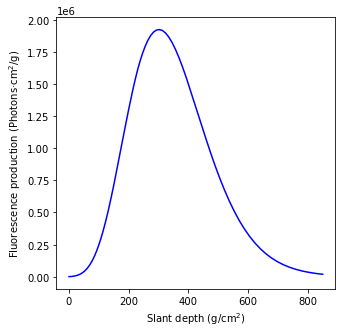

In [18]:
cherenkov.show();
fluorescence.show();

Help on `Fluorescence` and `Cherenkov`.

In [19]:
# fluorescence?
# cherenkov?

### `Shower` class

`Shower` contains all the information of a shower including its track, its longitudinal profile and its light production. Therefore, a `Shower` object wraps objects of the classes: `Atmosphere`, `Track`, `Profile`, `Cherenkov` and `Fluorescence`. This object can be generated in one step introducing all the input parameters (or keeping the default ones) of the constituent objects.

In [20]:
# Default Shower object
# shower = sm.Shower()

# Setting the impact point, energy, zenith and azimuth angles, X_max and atmospheric profile
shower = sm.Shower(x0=0.5, y0=0.1, E=1000000, theta=20., az= 30., X_max=300., h0=1.8, h_top=100., atm_model=17, N_steps=600)

The constituent objects are stored as attributes of `Shower`.

In [21]:
shower.atmosphere  # Equivalent to shower.profile.atmosphere
# shower.track
# shower.profile
# shower.fluorescence
# shower.cherenkov

,h,X_vert,rho,temp,P,P_w,E_th,r_M
0,1.881833,821.965364,1.018359e-03,275.745413,806.072664,3.725013e+00,23.437060,0.094346
1,2.045500,805.440347,1.001041e-03,274.876053,789.867157,3.421501e+00,23.638347,0.095978
2,2.209167,789.196339,9.840185e-04,273.991653,773.937228,3.142515e+00,23.841405,0.097638
3,2.372833,773.228562,9.672851e-04,273.091953,758.278188,2.886085e+00,24.046245,0.099327
4,2.536500,757.532320,9.508363e-04,272.176690,742.885433,2.650400e+00,24.252881,0.101046
...,...,...,...,...,...,...,...,...
595,99.263500,0.001372,1.269746e-09,369.119629,0.001345,2.690786e-09,20986.617375,75666.989023
596,99.427167,0.001351,1.241879e-09,371.748648,0.001325,2.650475e-09,21220.775631,77364.918179
597,99.590833,0.001331,1.214623e-09,374.436661,0.001306,2.611050e-09,21457.546509,79100.948012
598,99.754500,0.001312,1.187966e-09,377.184992,0.001286,2.572489e-09,21696.959158,80875.933481


Some attributes of `Track`, `Profile` and `Atmosphere` can also be accessed directly via attributes of `Shower`.

In [22]:
print("Depth of maximum:", shower.X_max)  # Equivalent to shower.profile.X_max
print("Coordinates of ground interaction point:",
      np.around([shower.x0, shower.y0], 3))  # Equivalent to (shower.track.x0, shower.track.y0)

Depth of maximum: 300.0
Coordinates of ground interaction point: [0.5 0.1]


There are some inherited methods as well.

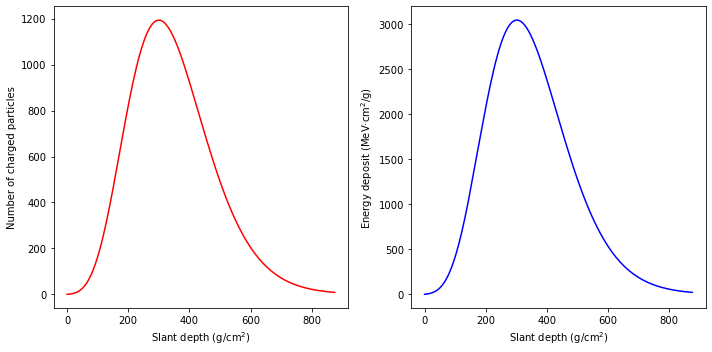

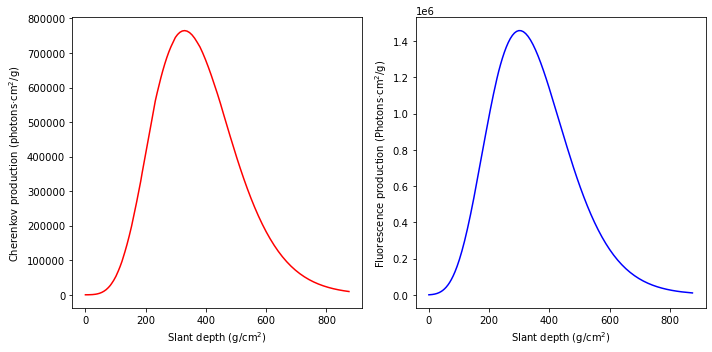

In [23]:
shower.show_profile();
shower.show_light_production();

Remarkably, there is a method of `Shower` to visualize the shower track projection with additional options with respect to the equivalent method of `Projection`.

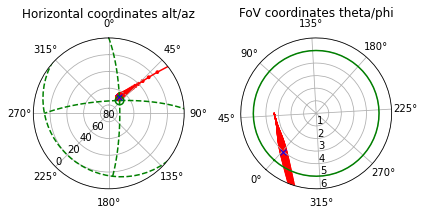

In [24]:
shower.show_projection(sm.Telescope(x=0.1, y=-0.2, z=0.1, alt=70., az=40.), max_theta=6.);

# Equivalent procedure
# telescope = sm.Telescope(x=0.1, y=-0.2, z=0.1, alt=70., az=40.)
# projection = shower.Projection(telescope)
# projection.show(max_theta=6., X_mark=shower.X_max);

Note 1: `X_mark` is set to `X_max` by default.  
Note 2: Size of track points are proportional to the energy deposited in each step length, which is approximately proportional to the light emission. This option can deactivated setting `shower_Edep=False`.

There is also a method to make copies of a `Shower` object with optional changes. This eases the iterative generation of showers as a function of a changing parameter. As already pointed out for `Atmosphere`, it is not advisalbe to modify directly a `Shower` object, since this would probably cause inconsistencies between its properties.

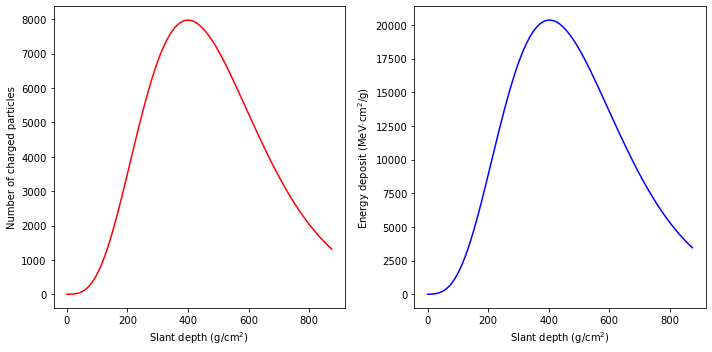

In [25]:
# Identical copy
# shower2 = shower.copy()

# Same atmosphere and track, but different profile, i.e., 10 TeV hadronic shower with depth of maximum at 400 g/cm2
shower2 = shower.copy(E=10.e6, X_max=400., prf_model='Gaisser-Hillas')
shower2.show_profile();

Help on `Shower`.

In [26]:
# sm.Shower?